# Data Consolidation to zarr store
This notebook aims to consolidate all the resistivity/metric data into a single xarray dataset and save it to a zarr store (locally for now)

## TODOs
- [x] Reshape data into 2D raster format
- [ ] Assing crs and transform
- [ ] Iterate and fill in all needed variables
- [ ] Try converting vector data to 2D raster coordinates.
- [ ] Check back with authors about naming of variables
- [ ] Optional for later: Refactor code to produce xarray data directly.

In [1]:
# Todo: Refactor backwards, but for now lets just cast this into an xarray Dataset
import dill
import xarray as xr
import numpy as np
from discretize import TensorMesh

output_dict = dill.load(open("./data_intermediate/output_metric_maps.pik", "rb")) # read binary produced by computation notebook
mesh = TensorMesh.read_UBC("./data_intermediate/mesh_orig.msh")

vector_space_dim = 'dim_xy'
threshold_dim = 'fraction'
fraction_coarse = xr.DataArray(output_dict['fc'], dims=[vector_space_dim])

# stack the fraction_threshold value as a new dimension
stacked_vars = {name:  xr.concat(
    [xr.DataArray(values, dims=[vector_space_dim]).expand_dims(fraction=[frac]) for frac,values in output_dict[name].items()],
    dim=threshold_dim,
) for name in output_dict.keys() if name not in ['fc', 'fc_thresholds']}

# path_length_norm = xr.concat(
#     [xr.DataArray(values, dims=[vector_space_dim]).expand_dims(fraction=[frac]) for frac,values in output_dict['path_length_norm'].items()],
#     dim=threshold_dim,
# )
ds = xr.Dataset({
    "fraction_coarse": fraction_coarse,
    **stacked_vars
})
ds

<xarray.Dataset> Size: 124MB
Dimensions:           (dim_xy: 1410149, fraction: 5)
Coordinates:
  * fraction          (fraction) float64 40B 0.1 0.2 0.5 0.8 0.9
Dimensions without coordinates: dim_xy
Data variables:
    fraction_coarse   (dim_xy) float64 11MB nan nan nan nan ... nan nan nan nan
    path_length_norm  (fraction, dim_xy) float64 56MB nan nan nan ... nan nan
    path_to_no_flow   (fraction, dim_xy) float64 56MB nan nan nan ... nan nan

In [4]:
#Use a ufunc to convert the entire xarray dataset to raster format
# more info here: https://docs.xarray.dev/en/stable/generated/xarray.apply_ufunc.html

def convert_to_raster_ufunc(xy_array):
    return mesh.reshape(xy_array.T, "CC", "CC", "M")

ds_raster = xr.apply_ufunc(
    convert_to_raster_ufunc,
    ds,
    input_core_dims=[[vector_space_dim]],
    output_core_dims=[["x", "y"]],
    vectorize=True
    )
ds_raster = ds_raster.assign_coords({
    "x": mesh.cell_centers_x,
    "y": mesh.cell_centers_y,
})

## fix percentage values (one could use pint-xarray here, but that is overkill for now IMO)
ds_raster['fraction'] = ds_raster['fraction'] * 100
ds_raster['fraction'].attrs = {'Units': '%'}

ds_raster['fraction_coarse'] = ds_raster['fraction_coarse'] * 100
ds_raster['fraction_coarse'].attrs = {'Units': '%'}

ds_raster


<xarray.Dataset> Size: 124MB
Dimensions:           (x: 871, y: 1619, fraction: 5)
Coordinates:
  * x                 (x) float64 7kB -2.269e+05 -2.265e+05 ... 1.211e+05
  * y                 (y) float64 13kB -3.482e+05 -3.478e+05 ... 2.99e+05
  * fraction          (fraction) float64 40B 10.0 20.0 50.0 80.0 90.0
Data variables:
    fraction_coarse   (x, y) float64 11MB nan nan nan nan ... nan nan nan nan
    path_length_norm  (fraction, x, y) float64 56MB nan nan nan ... nan nan nan
    path_to_no_flow   (fraction, x, y) float64 56MB nan nan nan ... nan nan nan

In [5]:
# Some values are -inf in the path_length_norm, messing with the plotting. 
# Lets set them to nan for now
ds_raster = ds_raster.where(ds_raster.pipe(np.isfinite), other=np.nan)

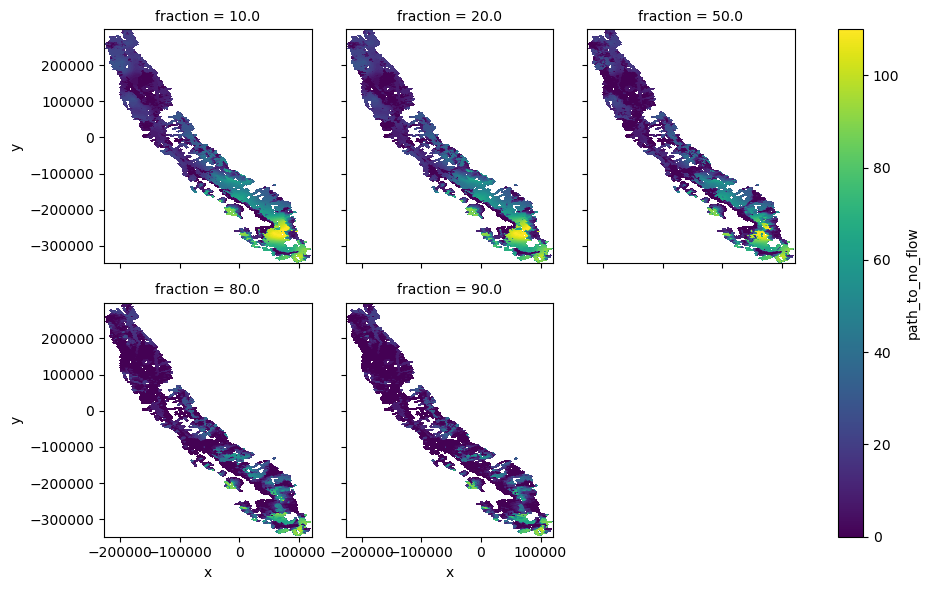

In [6]:
ds_raster['path_to_no_flow'].plot(col=threshold_dim, x='x', y='y', col_wrap=3, cmap='viridis')

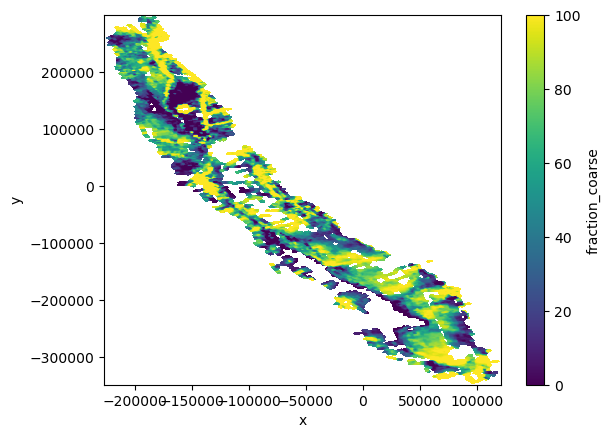

In [8]:
ds_raster['fraction_coarse'].plot(x='x', y='y', col_wrap=3, cmap='viridis')

In [9]:
ds_raster.to_zarr("./data_intermediate/consolidated_metric_output.zarr", mode="w")

/Users/juliusbusecke/miniforge3/envs/em_recharge/lib/python3.11/site-packages/zarr/api/asynchronous.py:244: ZarrUserWarning: Consolidated metadata is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  warnings.warn(
